In [7]:
%matplotlib inline

# Recap

In order of priority/time taken

1. basalareaincremementnonspatialaw
    - this is actually slow because of the number of times the BAFromZeroToDataAw function is called as shown above
    - relaxing the tolerance may help
    - indeed the tolerance is 0.01 * some value while the other factor finder functions have 0.1 tolerance i think
    - can also use cython for the increment functions

do a profiling run with IO (of reading input data and writing the plot curves to files) at end of this next run


# Decide on the action

- speed up increment functions
    - use cython for increment functions
    - it turns out this may not help that much. the function is pretty fast, it's called almost 500,000 times on the sample of 300 plots
    - cython actually is very fast in this type of case

# Characterize what is happening

n/a

### Timings

In [3]:
%%timeit
pass

The slowest run took 561.62 times longer than the fastest. This could mean that an intermediate result is being cached.
100000000 loops, best of 3: 10.6 ns per loop


In [2]:
%%timeit
pass

The slowest run took 287.17 times longer than the fastest. This could mean that an intermediate result is being cached.
100000000 loops, best of 3: 10.8 ns per loop


The array method is 20x faster. This is worth implementing. We should also add tests to help be explicity about the behaviour of these volume functions.

# Revise the code

Go on. Do it.

# Tests

Yes, data prep test is affected and the data updated.

The forward simulation test is also affected, significantly:

In [5]:
import pandas as pd

**diff is result-expected, so when negative, diff is larger in expected.**

In [9]:
diff = pd.read_csv('../private-data/cython-forward-sim-diff.csv', index_col=0)

In [26]:
sel = [i for i in diff.columns.tolist() if i.startswith('BA_')]

In [27]:
with pd.option_context('display.max_rows', 999):
    print(diff.loc[:,sel])

        BA_Aw     BA_Sw  BA_Sb      BA_Pl
0    0.000000  0.000000    0.0   0.000000
1    0.000000  0.000000    0.0   0.000000
2    0.000000  0.000000    0.0   0.000000
3    0.000000  0.000000    0.0   0.000000
4    0.000000  0.000000    0.0   0.000000
5    0.000000  0.000000    0.0   0.000000
6    0.000000  0.000000    0.0   0.000000
7    0.000000  0.000000    0.0   0.000000
8    0.000000  0.000000    0.0   0.000000
9    0.000000  0.000000    0.0   0.000000
10   0.000000  0.000000    0.0   0.000000
11   0.000000  0.000000    0.0   0.000000
12   0.000000  0.000000    0.0   0.000000
13  -0.001215  0.000000    0.0   0.000000
14  -0.005955  0.000000    0.0   0.000000
15  -0.016246  0.000000    0.0   0.000000
16  -0.033790  0.000000    0.0   0.000000
17  -0.059914  0.000000    0.0   0.000000
18  -0.095537  0.000000    0.0   0.000000
19  -0.104325  0.000000    0.0   0.000000
20  -0.115392  0.000000    0.0   0.000000
21  -0.128879  0.000000    0.0   0.000000
22  -0.144897  0.000000    0.0   0

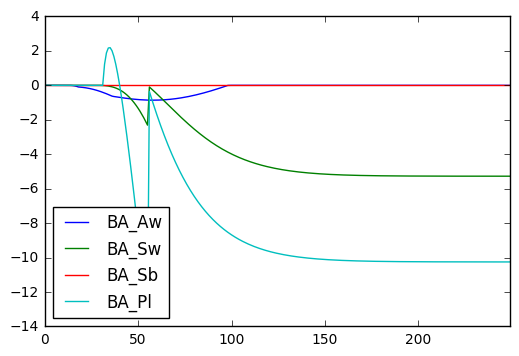

In [22]:
diff.loc[:,sel].plot()

I can tell if cython is the issue by removing cython and running tests:

In [ ]:
%%bash
mv ../gypsy/increment.pyx ../gypsy/increment.pyx
rm ../gypsy/increment.c ../gypsy/increment.so

# Review code changes

In [28]:
%%bash
git log --since "2016-11-15 16:00" --oneline # 16:00 GMT/UTC

ad78508 Add test differences to notebook
bffc17a Fixup log args & add notebook for optimization 4
c480ed2 Use allclose for dataprep test
c12142d Revise test data for data prep result
6e3afa7 Fixups for test reminders and data prep
9a9515d Update forward simulation for new increment module
8cdf262 Ignore cython generated .c files
7e9240d Update DataPrep to use new increment module
f805107 Fixup cython build
2e14fa0 Add cython to dev requirements
d5602a1 Configure to build cython extensions
fe29d3a Add docstring & make logger name PEP8 compliant
7eee18b Use PEP8 compliant function names
994d343 Move increment functions to own module
8aa3011 Add reminder for merch vol tests
bdee60c Add notes for vol vectorization yields


In [34]:
! git diff "HEAD~$(git log --since "2016-11-14 19:30" --oneline | wc -l)" ../gypsy

diff --git a/gypsy/GYPSYNonSpatial.py b/gypsy/GYPSYNonSpatial.py
index 7b93c0f..ec1d1fc 100644
--- a/gypsy/GYPSYNonSpatial.py
+++ b/gypsy/GYPSYNonSpatial.py
@@ -1381,82 +1381,88 @@ def BAfromZeroToDataPl(startTage, startTagePl, y2bh_Pl, SC_Pl, SI_bh_Pl,
     return basal_area_arr
 
 
-def GrossTotalVolume_Aw(BA_Aw, topHeight_Aw):
-    '''Gross total volume is estimated only using species specific Basal Area and
-    Top height
+def GrossTotalVolume_Aw(basal_area, top_height):
+    ''' White Aspen Gross Total Volume
 
-    :param float BA_Aw: basal area of Aw
-    :param float topHeight_Aw: top height of Aw
+    Note that inputs may be scalars, or numpy arrays.
+
+    :param float basal_area: basal area
+    :param float top_height: top height
 
     '''
-    Tvol_Aw = 0
+    a1 = 0.248718
+    a2 = 0.98568
+    a3 = 0.857278
+    a4 = -24.9961
+    tot_vol = a1 \
+              * (basal_area**a2) \
+              * (top_height**a3) \
+              * numpy.exp( 1 \
+                   

# Run timings

From last time:

```
real	5m36.407s
user	5m25.740s
sys 	0m2.140s
```

After cython'ing iter functions:

In [36]:
%%bash
# git checkout 36941343aca2df763f93192abef461093918fff4 -b vectorize-volume-functions
# time gypsy simulate ../private-data/prepped_random_sample_300.csv --output-dir tmp
# rm -rfd tmp

# real	4m51.287s
# user	4m41.770s
# sys	0m1.070s

In [38]:
45/336.

0.13392857142857142

It yielded a 13% reduction in the time.

# Run profiling

In [2]:
from gypsy.forward_simulation import simulate_forwards_df

In [3]:
data = pd.read_csv('../private-data/prepped_random_sample_300.csv', index_col=0, nrows=10)

In [4]:
%%prun -D forward-sim-3.prof -T forward-sim-3.txt -q
result = simulate_forwards_df(data)

 
*** Profile stats marshalled to file u'forward-sim-3.prof'. 

*** Profile printout saved to text file u'forward-sim-3.txt'. 


In [5]:
!head forward-sim-3.txt

         1076718 function calls (1074662 primitive calls) in 13.756 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   492069    6.234    0.000    6.234    0.000 GYPSYNonSpatial.py:428(BasalAreaIncrementNonSpatialAw)
     7191    2.179    0.000    8.563    0.001 GYPSYNonSpatial.py:956(BAfromZeroToDataAw)
    31044    0.734    0.000    0.734    0.000 GYPSYNonSpatial.py:585(BasalAreaIncrementNonSpatialSw)
    16426    0.338    0.000    0.338    0.000 GYPSYNonSpatial.py:683(BasalAreaIncrementNonSpatialPl)
    79970    0.279    0.000    0.348    0.000 {isinstance}


# Compare performance visualizations

Now use either of these commands to visualize the profiling

```
pyprof2calltree -k -i forward-sim-1.prof forward-sim-3.txt

# or

dc run --service-ports snakeviz notebooks/forward-sim-3.prof
```

### Old

![2nd iteration performance](forward-sim-2a-performance.png)

### New

![3nd iteration performance](forward-sim-3-performance.png)

## Summary of performance improvements

The calculation of gross and merchantable volume is drastically faster now; under profiling it decrease to 1 second from 22 seconds.

A lot of that seems to be profiler overhead, as when using gypsy simulate CLI it only got 15% faster; however I expect i/o is obfuscating the outcome there.


# Profile with I/O


In [ ]:
! rm -rfd gypsy-output

In [ ]:
output_dir = 'gypsy-output'

In [20]:
%%prun -D forward-sim-2.prof -T forward-sim-2.txt -q
# restart the kernel first
data = pd.read_csv('../private-data/prepped_random_sample_300.csv', index_col=0, nrows=10)
result = simulate_forwards_df(data)
os.makedirs(output_dir)
for plot_id, df in result.items():
    filename = '%s.csv' % plot_id
    output_path = os.path.join(output_dir, filename)
    df.to_csv(output_path)


 
*** Profile stats marshalled to file u'forward-sim-1.prof'. 

*** Profile printout saved to text file u'forward-sim-1.txt'. 


# Identify new areas to optimize



- from last time:
    - parallel (3 cores) gets us to 2 - 6 days - save for last
    - AWS with 36 cores gets us to 4 - 12 hours ($6.70 - $20.10 USD on a c4.8xlarge instance in US West Region)
    - aws lambda and split up the data 
- now:
    - cython for increment functions epsecially bA
    - i/o